Trabajo Practico 2

In [21]:
# LIBRERIAS
import numpy as np
from PIL import Image, ImageOps
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from itertools import product

1. Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.
a) Verifique si la red aprendió las imágenes enseñadas.
b) Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes
aprendidas: agregado de ruido, elementos borrados o agregados.
c) Evalúe la existencia de estados espurios en la red: patrones inversos y
combinaciones de un número impar de patrones. (Ver Spurious States, en la sección
2.2, Hertz, Krogh & Palmer, pág. 24).
d) Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de
aprender todas las imágenes? Explique.

In [224]:
# FUNCIONES PRINCIPALES

# Para pasar de patron a BMP
def patternToBMPImage(S, width, height):
    if len(S) > width * height:
        S = S[:width * height]
    imgArray = np.reshape(S, (height, width))  # Ajustar a (alto, ancho)
    imgArray = imgArray + np.ones((height, width))
    imgArray = (imgArray * 127.5).astype(np.uint8)  # Convertir de 0/1 a 0/255

    return Image.fromarray(imgArray)

# Para mostrar el progreso de la imagen adaptandose 
def showImageProgress(input, height, width, t):
    currentImg = patternToBMPImage(input, width, height)
    display(currentImg)
    time.sleep(t * 1e-3)
    clear_output(wait=True)

# Para hacer update sync
def hopfieldUpdateSync(weights, input, index):
    localField = np.dot(weights[index], input)
    newState = np.sign(localField)
    if newState == 0:
        newState = 1
    hasUpdated = newState != input[index]
    input[index] = newState

    return hasUpdated

# Hopfield sync
def hopfieldSync(weights, input, height=0, width=0, show=False, t=1):
    N = height * width
    updates = 0
    max_iterations = len(input) * 10  # Evitar bucles infinitos

    for iteration in range(max_iterations):
        current_updates = 0
        for i in range(len(input)):
            update = hopfieldUpdateSync(weights, input, i)
            current_updates += update
            if update and show and N != 0:
                showImageProgress(input, height, width, t)
        
        updates += current_updates
        if current_updates == 0:
            break  # Si no hubo actualizaciones, salimos del bucle
    
    if show and updates > 0:
        time.sleep(1.5)

    return updates

def hopfieldUpdateSyncNEW(weights, input, index):
    updates = 0
    h = np.dot(weights[index], input)
    S_updated = np.sign(h)
    # Hertz book sign() function definition. 
    if S_updated == 0:
        S_updated = 1
    if S_updated != input[index]:
        updates = 1
    return S_updated, updates

def hopfieldSyncNEW(weights, input, height=0, width=0):
    S_sync = input.copy()
    updates = 0
    for i in range(len(input)):
        S_sync[i], update = hopfieldUpdateSyncNEW(weights, input, i)
        updates += update
    input[:] = S_sync[:]
    return updates

# Para hacer update unsync
def hopfieldUpdateUnsync(weights, input, index):
    localField = np.dot(weights[index], input)
    newState = np.sign(localField)
    if newState == 0:
        newState = 1
    hasUpdated = newState != input[index]
    input[index] = newState
    
    return hasUpdated

# Hopfield sync - REVISAR
def hopfieldUnsync(weights, input, height=0, width=0, show=False, t=1):
    length = len(input)
    N = height * width
    updates = 0
    randomUpdateIndexes = np.random.permutation(length)

    for i in range(length):
        update = hopfieldUpdateUnsync(weights, input, randomUpdateIndexes[i])
        updates += update
        if update and show and N != 0:
            showImageProgress(input, height, width, t)

    if show and updates > 0:
        time.sleep(1.5)

    return updates

# Convierte imagen a patron
def imageToPattern(img):
    vector = np.array(img).astype(int)
    vector = vector.flatten() # Imagen como vector

    return 2 * vector - 1 # Patrones de -1 o 1

# Carga una imagen y la combierte a un patron
def loadImageAndConvertToPattern(path):
    image = Image.open(path).convert('1')  # Convertir a unos y ceros
    pattern = imageToPattern(image)

    return image, pattern

# Muestra imagenes
def showImages(images):
    for img in images:
        display(img)

# Arma la matriz de pesos
def computeWeights(patterns):
    length = len(patterns[0]) # Largo de un patron
    weights = np.zeros((length, length), float)

    for pattern in patterns:
        weights += np.outer(pattern, pattern)

    np.fill_diagonal(weights, 0) # Elimino la diagonal para pesos de autoconexiones

    return weights

Imagen original 1:


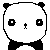

Imagen recuperada 1:


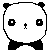

La red aprendió la imagen 1 suministrada.
Imagen original 2:


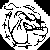

Imagen recuperada 2:


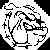

La red aprendió la imagen 2 suministrada.
Imagen original 3:


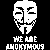

Imagen recuperada 3:


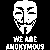

La red aprendió la imagen 3 suministrada.


In [225]:
# VERIFICACION DE APRENDIZAJE

# Imagenes 45x60
paths45x60 = ['ImgTP2/paloma.bmp', 'ImgTP2/quijote.bmp', 'ImgTP2/torero.bmp']
# Imagenes 50x50
paths50x50 = ['ImgTP2/panda.bmp', 'ImgTP2/perro.bmp', 'ImgTP2/v.bmp']

# Convertir a patron
images45x60, patterns45x60 = zip(*(loadImageAndConvertToPattern(path) for path in paths45x60))
images50x50, patterns50x50 = zip(*(loadImageAndConvertToPattern(path) for path in paths50x50))

# Selecciono las imagenes a aprender
images = images50x50
patterns = patterns50x50
#images = images45x60
#patterns = patterns45x60

[width, height] = images[0].size

weights = computeWeights(patterns)
inputs = [pattern.copy() for pattern in patterns]
sync = True

for i, input in enumerate(inputs):
    print(f"Imagen original {i+1}:")
    display(images[i])

    show = True
    updates = 0

    if sync:
        updates = hopfieldSyncNEW(weights, input, height, width)
    else:
        updates = hopfieldUnsync(weights, input, height, width, show)
    
    print(f"Imagen recuperada {i+1}:")
    recoveredImage = patternToBMPImage(input, width, height)
    display(recoveredImage)

    if updates == 0:
        print(f'La red aprendió la imagen {i+1} suministrada.')
        time.sleep(1)


In [226]:
# FUNCIONES DE VARIACIONES

# Agrega ruido 
def addNoise(pattern, noise_level=0.1):
    noisy_pattern = pattern.copy()
    num_noisy_elements = int(noise_level * len(pattern))
    noisy_indices = np.random.choice(len(pattern), num_noisy_elements, replace=False)
    noisy_pattern[noisy_indices] *= -1  # Invertir el estado de los elementos seleccionados

    return noisy_pattern

# Borra elementos (Blanco = 1)
def removeElements(pattern, removal_level=0.1):
    removed_pattern = pattern.copy()
    num_removed_elements = int(removal_level * len(pattern))
    removed_indices = np.random.choice(len(pattern), num_removed_elements, replace=False)
    for idx in removed_indices:
        if removed_pattern[idx] == -1:
            removed_pattern[idx] = 1

    return removed_pattern

# Agrega elementos (Negro = -1)
def addElements(pattern, addition_level=0.1):
    added_pattern = pattern.copy()
    num_added_elements = int(addition_level * len(pattern))
    added_indices = np.random.choice(len(pattern), num_added_elements, replace=False)
    for idx in added_indices:
        if added_pattern[idx] == 1:
            added_pattern[idx] = -1

    return added_pattern

# Evaluar la evolución de la red con versiones alteradas de las imágenes
def evaluateNetworkAlteredImages(weights, patterns, height, width, alteration_fn, alteration_level=0.1, sync=True, title="Evaluación"):
    # La alteracion se realiza con la funcion alteration_fn
    altered_patterns = [alteration_fn(pattern, alteration_level) for pattern in patterns]
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)
    row = 0

    for i, (original_pattern, altered_pattern) in enumerate(zip(patterns, altered_patterns)):
        original_image = patternToBMPImage(original_pattern, width, height)
        altered_image = patternToBMPImage(altered_pattern, width, height)
        input_pattern = altered_pattern.copy()
        
        if sync:
            hopfieldSyncNEW(weights, input_pattern, height, width)
        else:
            hopfieldUnsync(weights, input_pattern, height, width, show=False)
        
        recovered_image = patternToBMPImage(input_pattern, width, height)
        
        # Mostrar las imágenes en el gráfico
        axes[row, 0].imshow(original_image, cmap='gray')
        axes[row, 0].set_title(f'Original {i+1}')
        axes[row, 0].axis('off')
        axes[row, 1].imshow(altered_image, cmap='gray')
        axes[row, 1].set_title(f'Alterada {i+1}')
        axes[row, 1].axis('off')
        axes[row, 2].imshow(recovered_image, cmap='gray')
        axes[row, 2].set_title(f'Recuperada {i+1}')
        axes[row, 2].axis('off')
        row = row + 1
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Genera el patrón inverso
def generateInversePattern(pattern, alteration_level):
    return -pattern

# Genera todas las combinaciones posibles de un número impar de patrones
def generateAllMixturePatterns(patterns):
    num_patterns = len(patterns)
    all_combinations = []

    # Generar todas las combinaciones de signos para los patrones
    for signs in product([-1, 1], repeat=num_patterns):
        # Solo queremos combinaciones de un número impar de signos positivos
        if sum(signs) % 2 == 1:
            combined_pattern = np.sign(np.sum([sign * pattern for sign, pattern in zip(signs, patterns)], axis=0))
            all_combinations.append((signs, combined_pattern))

    return all_combinations

# Evaluar todas las combinaciones posibles de las imágenes (Estados espurios)
def evaluateAllMixturePatterns(weights, patterns, height, width, sync=True, title="Evaluación de Combinaciones de Patrones"):
    mixture_patterns = generateAllMixturePatterns(patterns)
    
    fig, axes = plt.subplots(len(mixture_patterns), 2, figsize=(10, 5 * len(mixture_patterns)))
    fig.suptitle(title, fontsize=16)

    for i, (signs, mixture_pattern) in enumerate(mixture_patterns):
        combination_detail = ' + '.join([f'{"-" if sign == -1 else ""}p{j+1}' for j, sign in enumerate(signs)])
        altered_image = patternToBMPImage(mixture_pattern, width, height)
        input_pattern = mixture_pattern.copy()
        
        if sync:
            hopfieldSyncNEW(weights, input_pattern, height, width)
        else:
            hopfieldUnsync(weights, input_pattern, height, width, show=False)
        
        recovered_image = patternToBMPImage(input_pattern, width, height)
        
        # Mostrar las imágenes en el gráfico
        axes[i, 0].imshow(altered_image, cmap='gray')
        axes[i, 0].set_title(f'Patrón Mixto: {combination_detail}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(recovered_image, cmap='gray')
        axes[i, 1].set_title(f'Recuperada {i+1}')
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


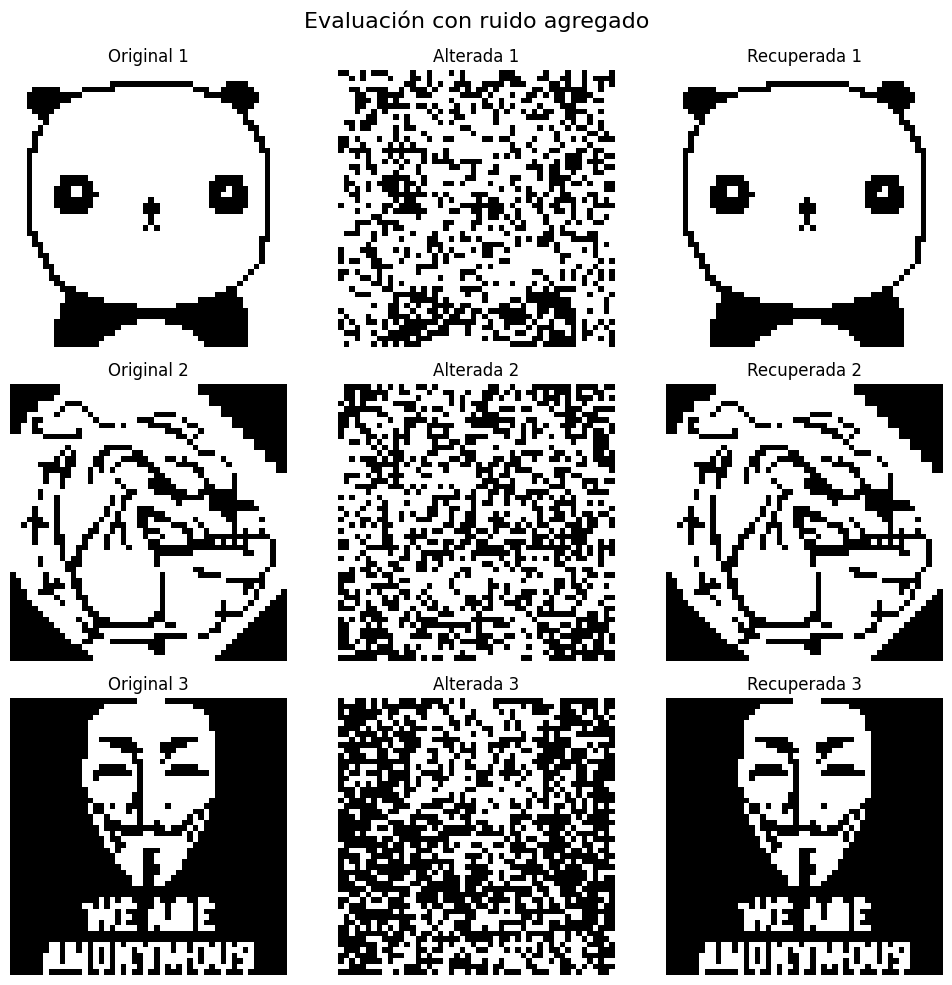

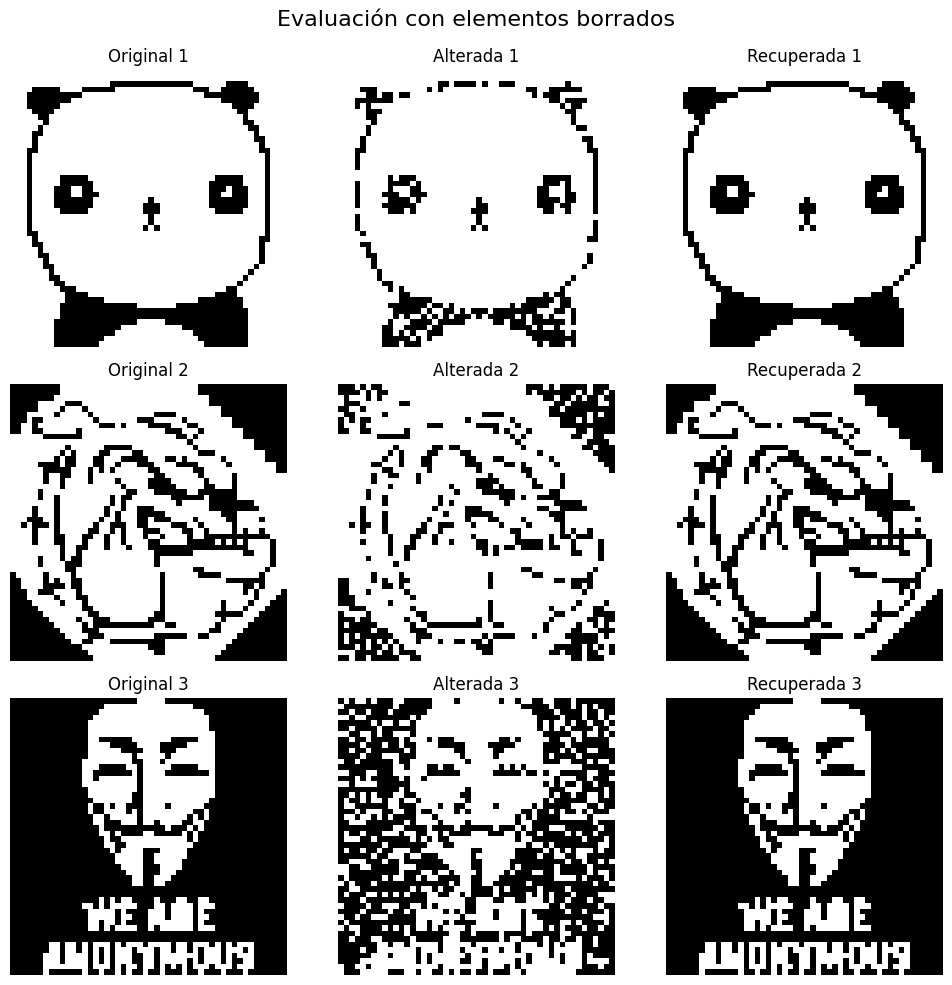

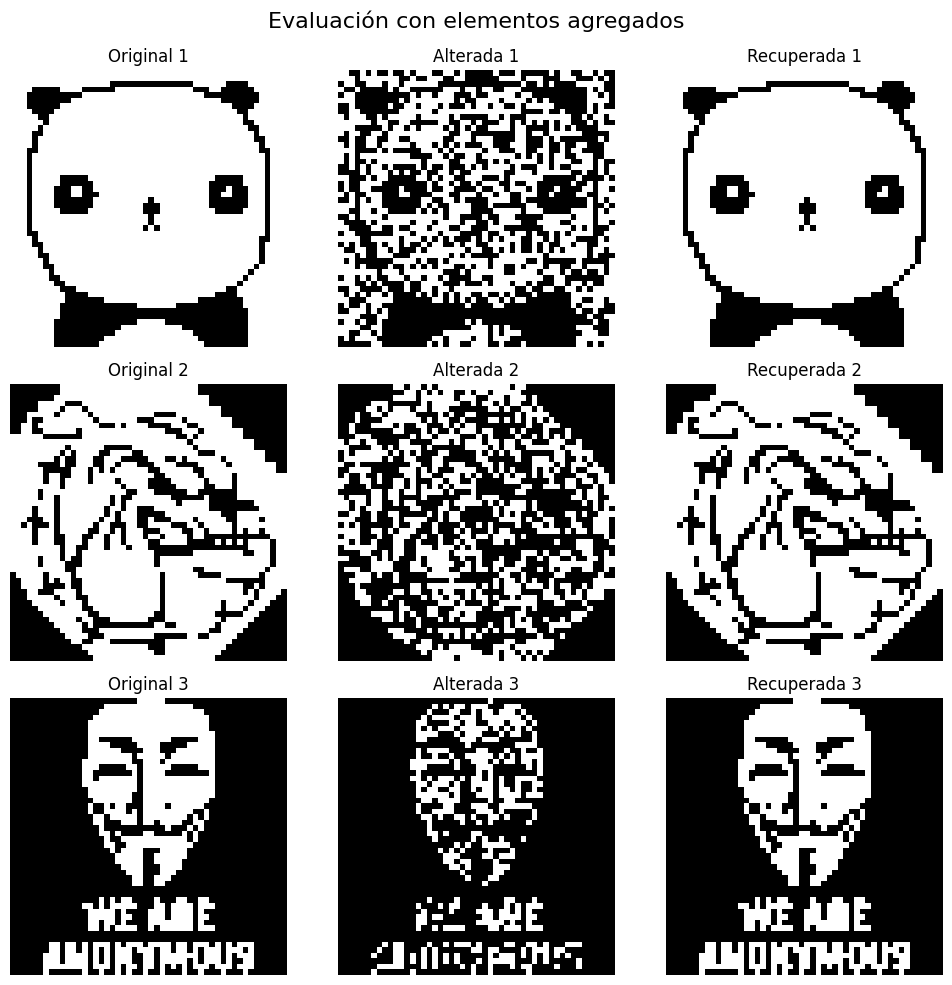

In [227]:
# VARIACIONES
title_noise = "Evaluación con ruido agregado"
title_removal = "Evaluación con elementos borrados"
title_addition = "Evaluación con elementos agregados"
# Parámetros de alteración
noise_level = 0.3
removal_level = 0.3
addition_level = 0.4

# Agregar ruido a las imagenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, addNoise, noise_level, sync, title_noise)
# Borrar elementos de las imagenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, removeElements, removal_level, sync, title_removal)
# Agregar elementos a las imagenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, addElements, addition_level, sync, title_addition)

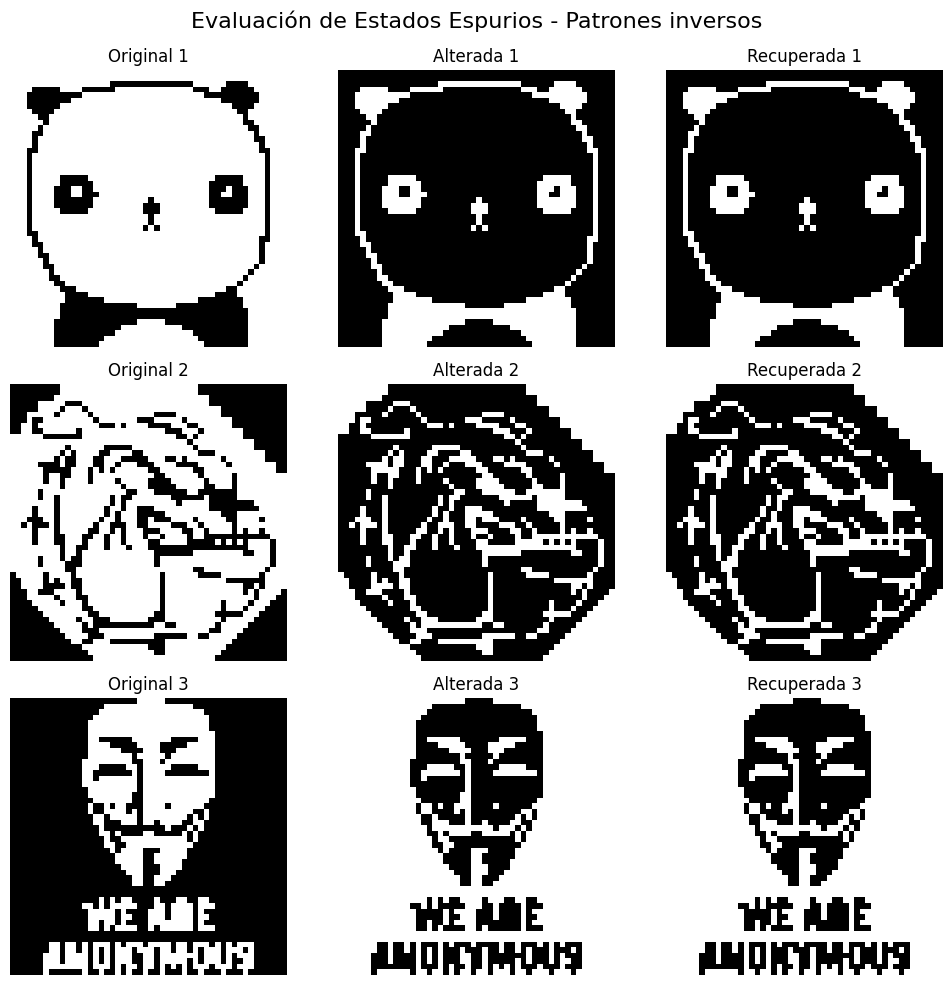

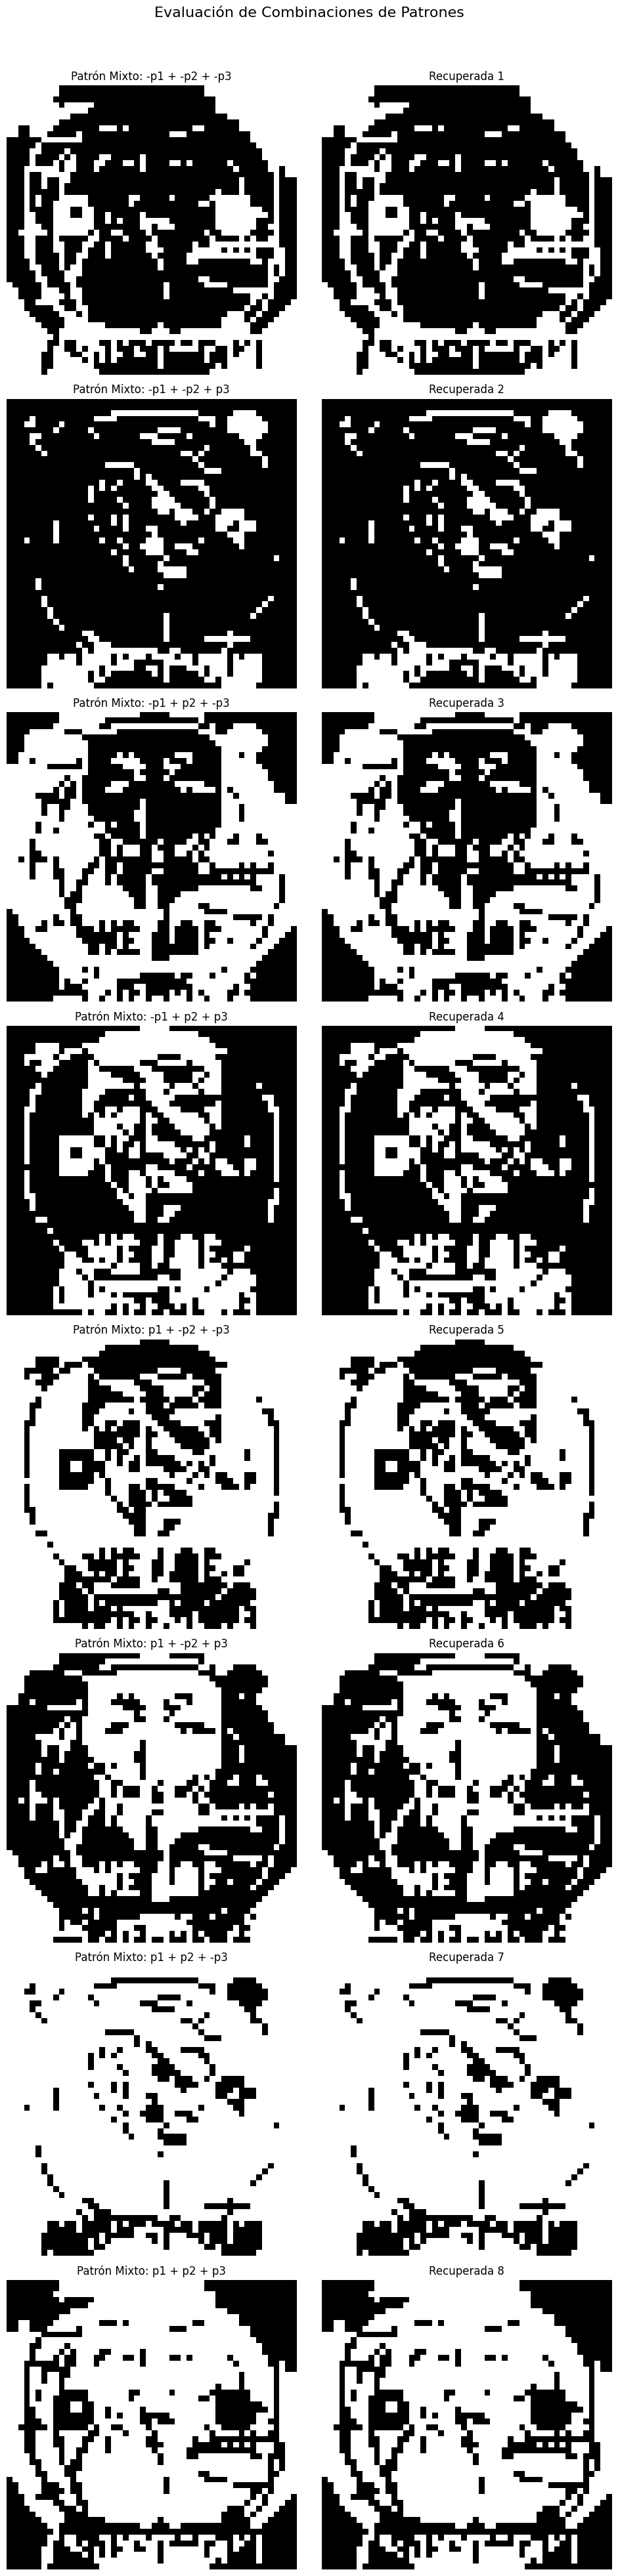

In [229]:
# ESTADOS ESPURIOS
title_inverse = "Evaluación de Estados Espurios - Patrones inversos"
# Evaluar la red con patrones inversos
evaluateNetworkAlteredImages(weights, patterns, height, width, generateInversePattern, title=title_inverse)

title_mixture = "Evaluación de Combinaciones de Patrones"
# Evaluar la red con combinaciones de patrones
evaluateAllMixturePatterns(weights, patterns, height, width, sync, title_mixture)

In [178]:
# FUNCIONES DE REDIMENSIONAMIENTO
# Rellena los bordes de negro para llegar hacer coincidir los tamaños
def padImageBlack(image, target_width, target_height):
    delta_width = target_width - image.width
    delta_height = target_height - image.height
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))

    return ImageOps.expand(image, padding, fill=0)

# Rellena los bordes con ruido
def padImageNoise(image, target_width, target_height):
    delta_width = target_width - image.width
    delta_height = target_height - image.height
    padding_left = delta_width // 2
    padding_right = delta_width - padding_left
    padding_top = delta_height // 2
    padding_bottom = delta_height - padding_top

    noise = np.random.choice([0, 255], (target_height, target_width)).astype(np.uint8)
    noise_image = Image.fromarray(noise, mode=image.mode)

    noise_image.paste(image, (padding_left, padding_top))

    return noise_image

# Function to resize images to a common size
def resizeImagesToCommonSize(images):
    max_width = max(image.width for image in images)
    max_height = max(image.height for image in images)
    
    resized_images = [padImageNoise(image, max_width, max_height) for image in images]

    return resized_images, max_width, max_height


La red aprendió la imagen 1
La red aprendió la imagen 2
La red aprendió la imagen 3
La red aprendió la imagen 5
La red aprendió la imagen 6


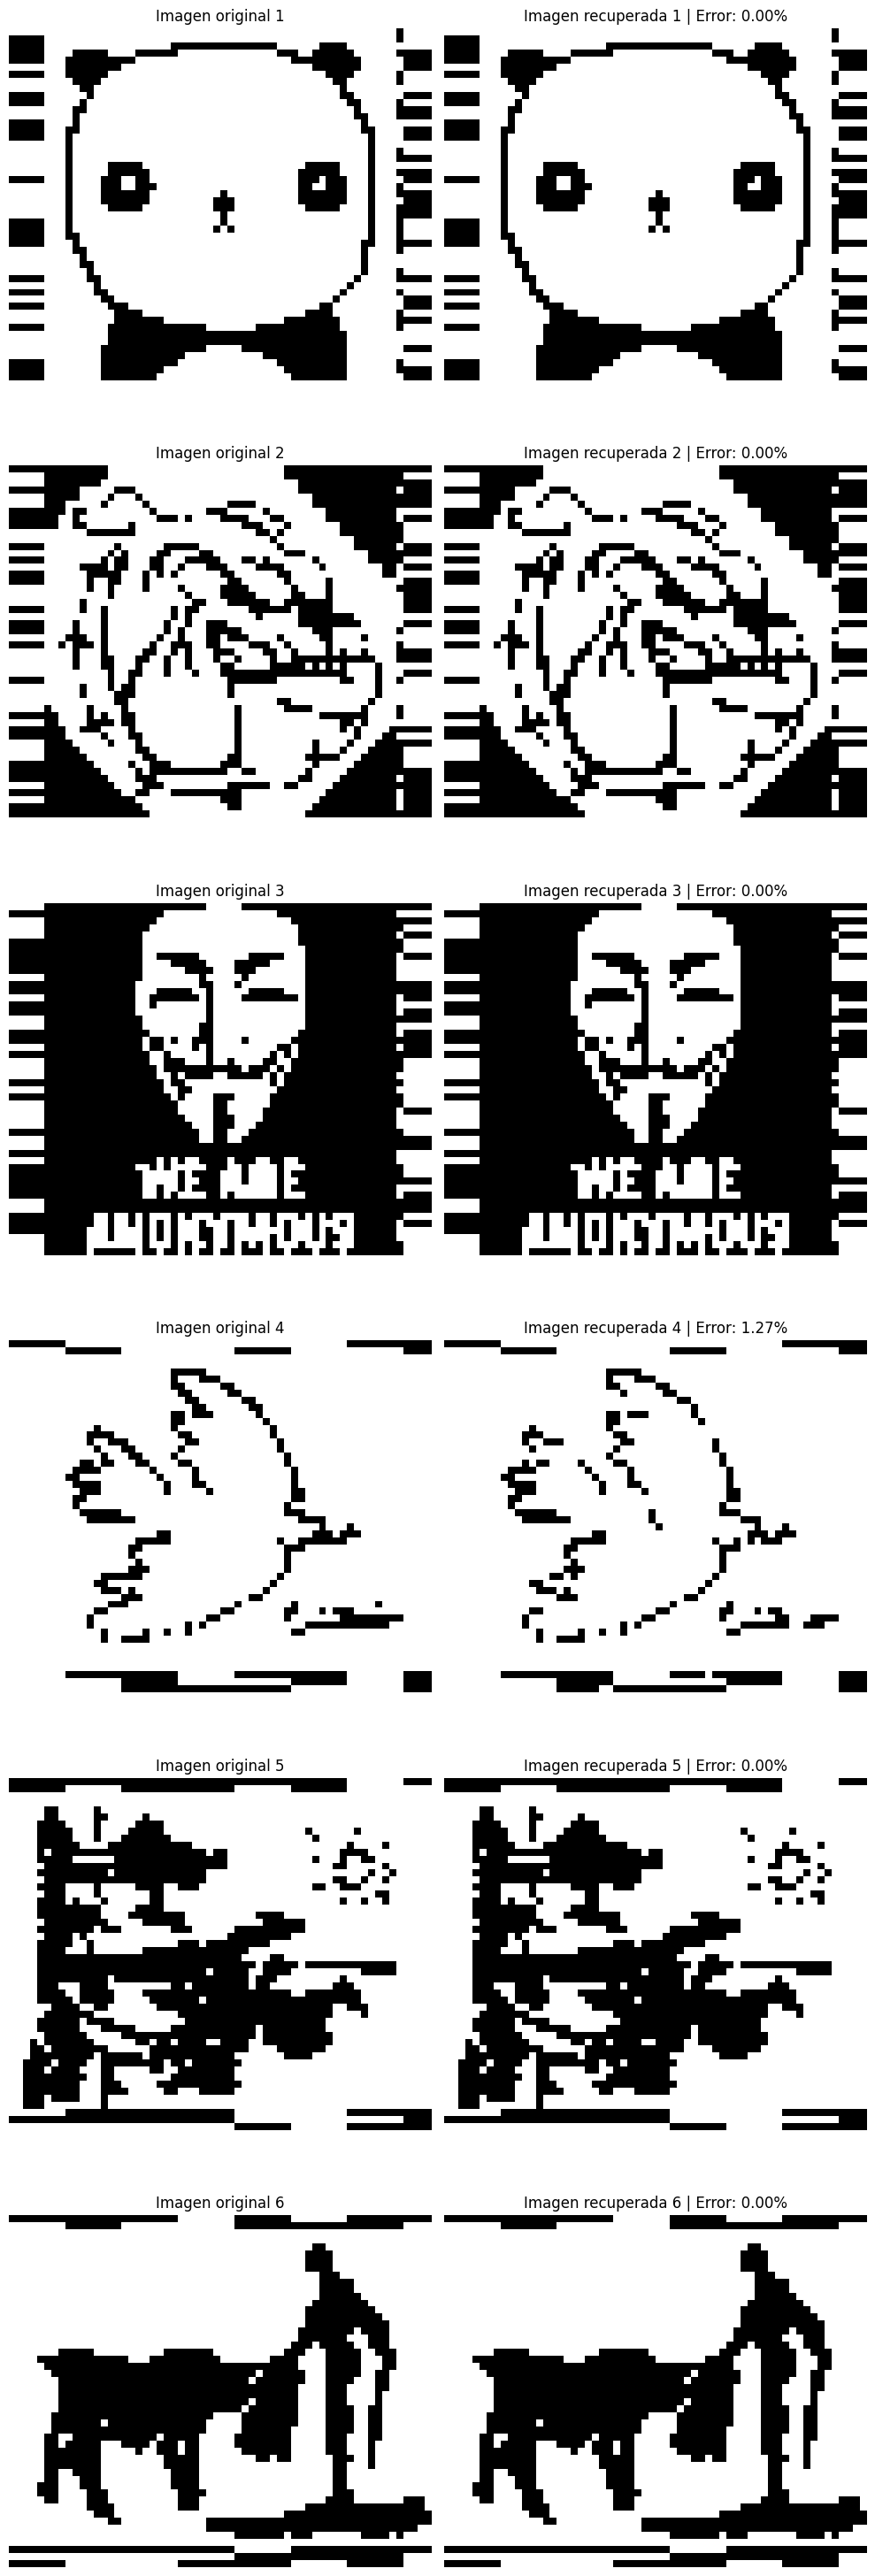

In [230]:
# ENTRENAMIENTO CON TODAS LAS IMÁGENES
images = list(images50x50) + list(images45x60)
resized_images, common_width, common_height = resizeImagesToCommonSize(images)

patterns = [imageToPattern(image) for image in resized_images]
weights = computeWeights(patterns)

inputs = [pattern.copy() for pattern in patterns]
sync = True

fig, axes = plt.subplots(len(inputs), 2, figsize=(10, 5 * len(inputs)))

for i, input in enumerate(inputs):
    original_image = resized_images[i]
    
    show = False
    updates = 0

    if sync:
        updates = hopfieldSyncNEW(weights, input, common_height, common_width)
    else:
        updates = hopfieldUnsync(weights, input, common_height, common_width, show)
    
    error_percentage = 100 * updates / (common_width * common_height)
    
    recovered_image = patternToBMPImage(input, common_width, common_height)
    
    # Plot original and recovered images
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title(f'Imagen original {i+1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(recovered_image, cmap='gray')
    axes[i, 1].set_title(f'Imagen recuperada {i+1} | Error: {error_percentage:.2f}%')
    axes[i, 1].axis('off')

    if updates == 0:
        print(f'La red aprendió la imagen {i+1}')
        time.sleep(1)

plt.tight_layout()
plt.show()

2.
a) Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño de la red. Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteración con actualización sincrónica).
        Perror  pmax/N
        0,001   0,105
        0,0036  0,138
        0,01    0,185
        0,05    0,37
        0,1     0,61
(Tabla 2.1, sección 2.2, Hertz, Krogh & Palmer, pág. 19)
b) Analice cómo cambia la capacidad de una red en función de la correlación entre patrones

In [267]:
# CAPACIDAD - FUNCIONES

# Tabla 2.1, sección 2.2, Hertz, Krogh & Palmer, pág. 19
P_error = np.array([0.001, 0.0036, 0.01, 0.05, 0.1])
p_max_N = np.array([0.105, 0.138, 0.185, 0.37, 0.61])

# Generar patrón aleatorio
def generateRandomPattern(N):
    return np.random.choice([-1, 1], size=N)

# Simulación de Red de Hopfield
def simulateHopfieldNetwork(N, P_error, p_max_N, experiments, p_max_N_experimental):
    for k in range(experiments):
        random_patterns = []

        for m, p_error in enumerate(P_error):
            #print("P_error: ", p_error)
            learning = True

            while learning:
                random_patterns.append(generateRandomPattern(N))
                W = computeWeights(random_patterns)
                bad_bits = 0

                for pattern in random_patterns:
                    input_pattern = np.copy(pattern)
                    bad_bits += hopfieldSyncNEW(W, input_pattern)
                    P_e = float(bad_bits / len(random_patterns) / N)
                    #print(f"N = {N}, Experiment = {k}, P_error = {p_error}, P_e = {P_e}, Patterns = {len(random_patterns)}")

                    if P_e > p_error:
                        p_max_N_experimental[k][m] = len(random_patterns) - 1
                        learning = False
    p_max_mean = np.mean(p_max_N_experimental, axis=0)

    return p_max_mean / N

# CAPACIDAD VS CORRELACIÓN - FUNCIONES
# Generar patrón correlacionado
def generateCorrelatedPattern(N, rho, mean):
    cov_matrix = np.ones((N, N)) * rho
    np.fill_diagonal(cov_matrix, 1)
    correlated_vector = np.random.multivariate_normal(mean, cov_matrix, 1)
    correlated_pattern = np.where(correlated_vector >= 0, 1, -1)[0]
    return correlated_pattern

# Simulación de Red de Hopfield con patrones correlacionados
def simulateHopfieldNetworkCorrelation(N_values, P_errors, correlation_levels):
    results = []

    for N in N_values:
        N_results = {"N": N, "P_errors": P_errors, "rho": correlation_levels, "p_max_experimental": []}
        mean = np.zeros(N)

        for p_error in P_errors:
            p_max_experimental = []

            for rho in correlation_levels:
                correlated_patterns = []
                learning = True

                while learning:
                    correlated_pattern = generateCorrelatedPattern(N, rho, mean)
                    correlated_patterns.append(correlated_pattern)
                    W = computeWeights(correlated_patterns)
                    bad_bits = 0

                    for pattern in correlated_patterns:
                        input_pattern = pattern.copy()
                        bad_bits += hopfieldSyncNEW(W, input_pattern)

                    P_e = float(bad_bits / (len(correlated_patterns) * N))
                    if P_e > p_error:
                        p_max_experimental.append(len(correlated_patterns) - 1)
                        learning = False

            N_results["p_max_experimental"].append(p_max_experimental)

        results.append(N_results)

    return results

In [268]:
# CAPACIDAD - SIMULACIÓN
N_values = [32, 64, 128, 256]
experiments = 10 
p_max_N_experimental_for_N = np.zeros((len(N_values), len(P_error)), float)
p_max_N_experimental = np.zeros((experiments, len(P_error)), int) 

for idx, N in enumerate(N_values):
    print("N: ", N)
    p_max_N_experimental_mean = simulateHopfieldNetwork(N, P_error, p_max_N, experiments, p_max_N_experimental)
    print(p_max_N_experimental_mean)
    p_max_N_experimental_for_N[idx] = p_max_N_experimental_mean

N:  32
[0.159375 0.190625 0.225    0.35     0.565625]
N:  64
[0.13125   0.1671875 0.2046875 0.3765625 0.6140625]
N:  128
[0.1125     0.13671875 0.190625   0.36796875 0.60546875]
N:  256
[0.1046875  0.1375     0.18203125 0.371875   0.609375  ]


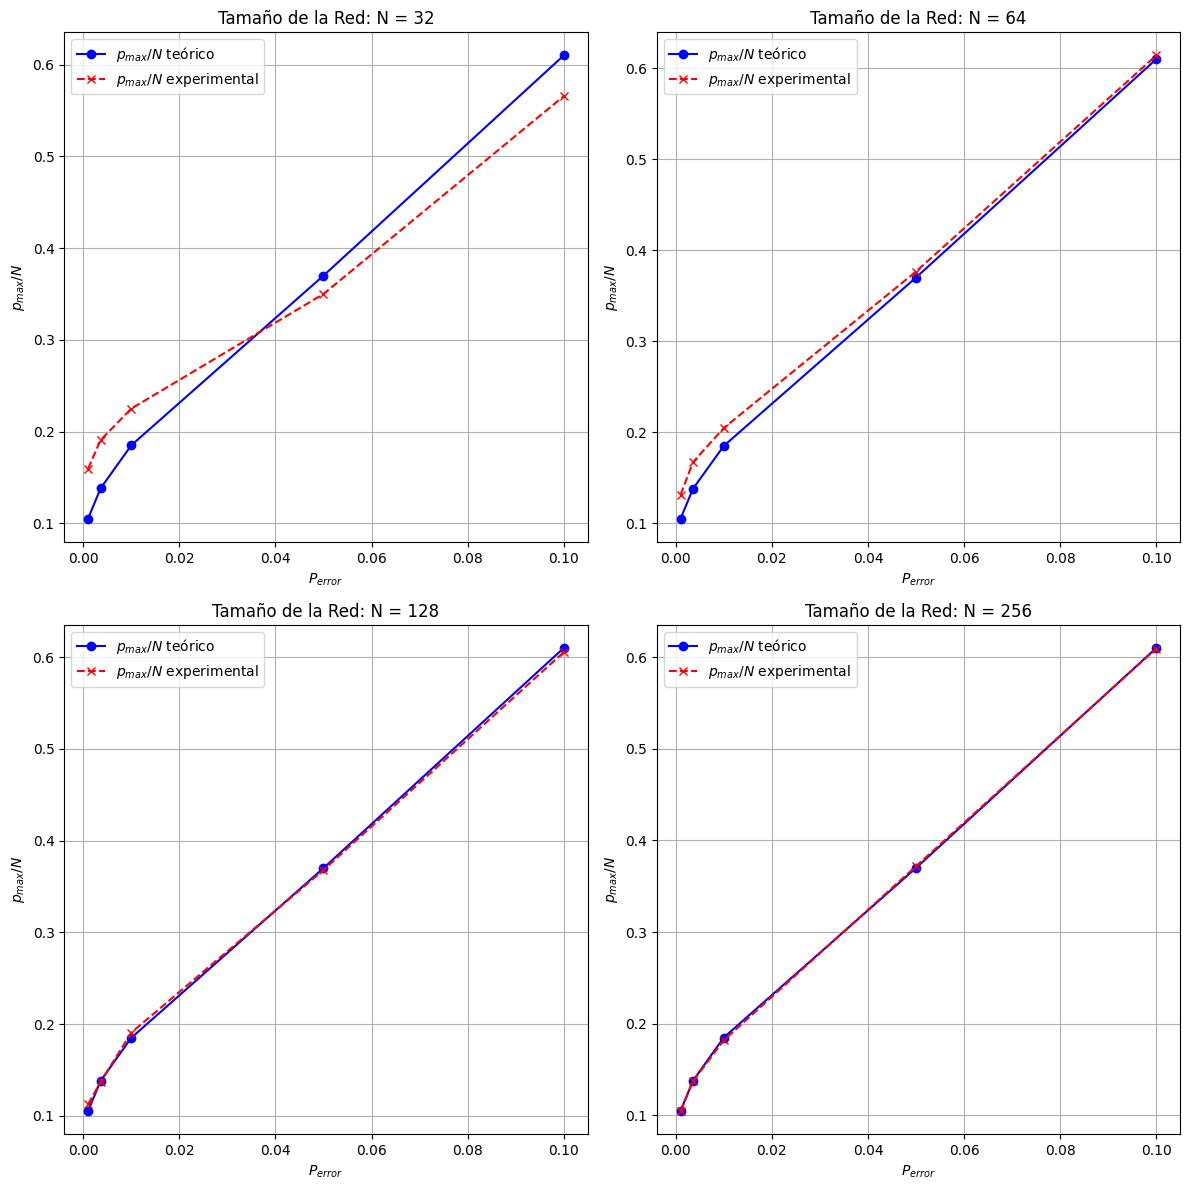

In [269]:
# CAPACIDAD - GRÁFICO

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for idx, N in enumerate(N_values):
    i, j = divmod(idx, 2)   
    ax[i][j].plot(P_error, p_max_N, 'o-', color='blue', label='$p_{max}/N$ teórico')
    ax[i][j].plot(P_error, p_max_N_experimental_for_N[idx], 'x--', color='red', label='$p_{max}/N$ experimental')
    ax[i][j].set_title(f'Tamaño de la Red: N = {N}')
    ax[i][j].set_xlabel('$P_{error}$')
    ax[i][j].set_ylabel('$p_{max}/N$')
    ax[i][j].legend()
    ax[i][j].grid()

plt.tight_layout()
plt.show()

In [263]:
# CAPACIDAD VS CORRELACIÓN - SIMULACIÓN
N_values = [32, 64, 128, 256]
P_errors = [0.001, 0.0036, 0.01, 0.05, 0.1]
rho_min = 0
rho_max = 0.85
correlation_levels = np.linspace(rho_min, rho_max, 50)

simulation_results = simulateHopfieldNetworkCorrelation(N_values, P_errors, correlation_levels)

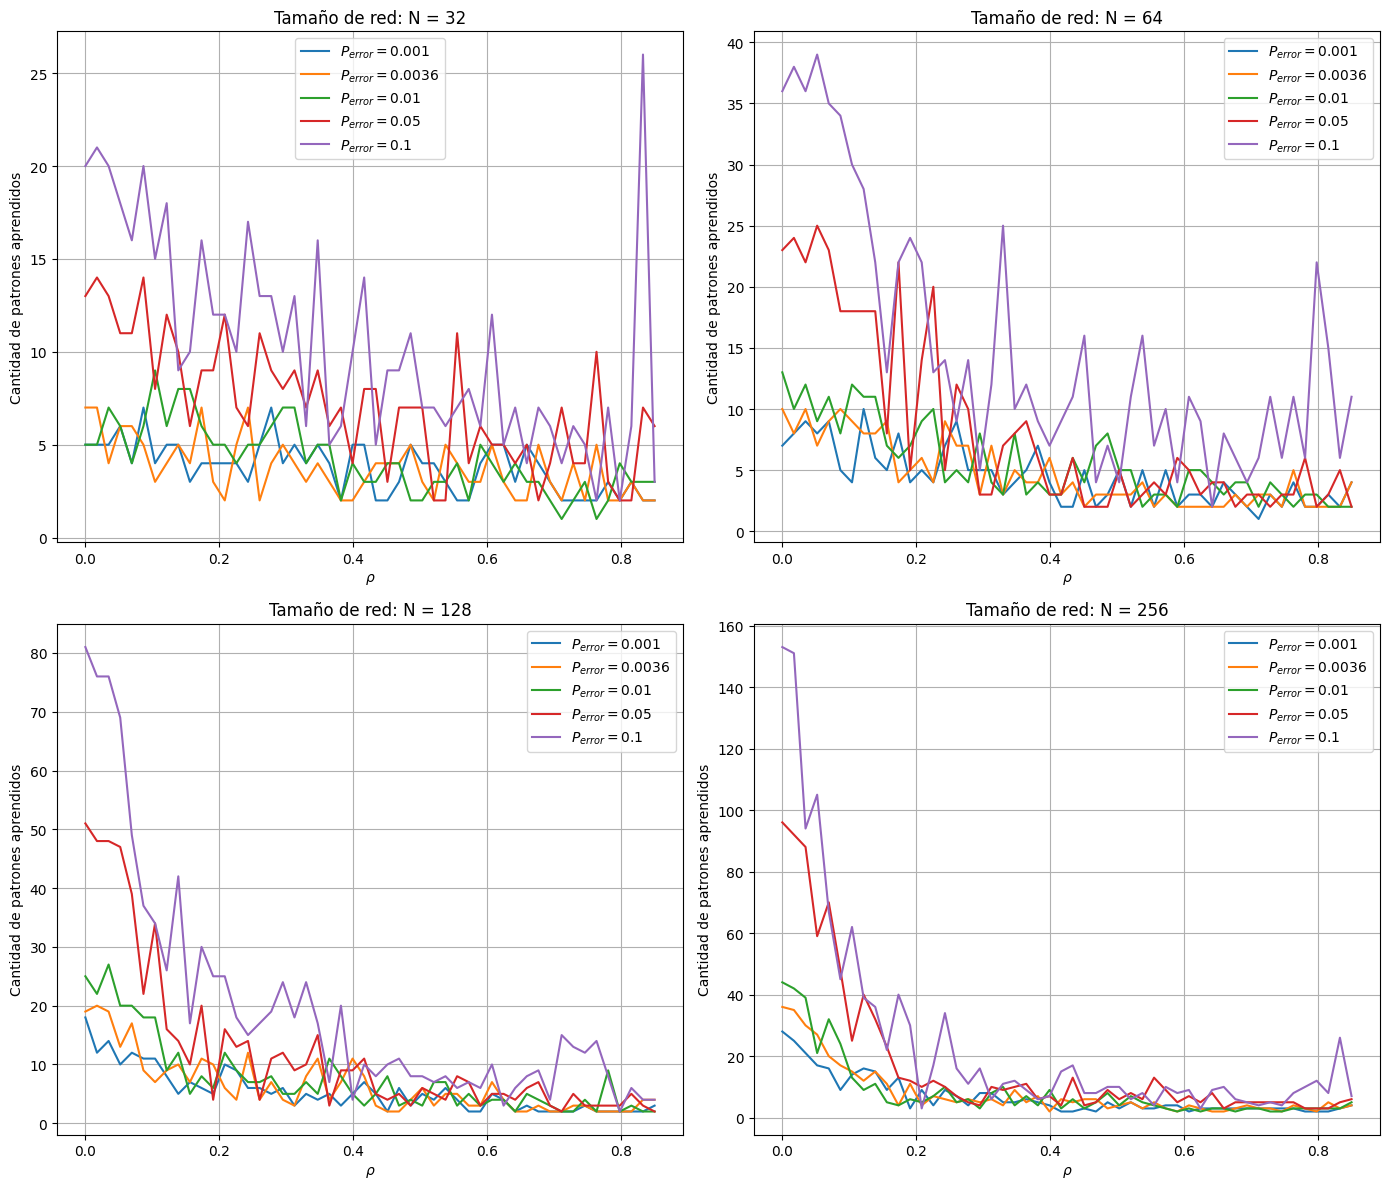

In [264]:
# CAPACIDAD VS CORRELACIÓN - GRÁFICOS
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

for i, result in enumerate(simulation_results):
    N = result["N"]
    P_errors = result["P_errors"]
    rho = result["rho"]
    p_max_experimental_all = result["p_max_experimental"]

    for j, p_max_experimental in enumerate(p_max_experimental_all):
        p_error = P_errors[j]
        axs[i].plot(rho, p_max_experimental, label=f'$P_{{error}} = {p_error}$')

    axs[i].set_title(f'Tamaño de red: N = {N}')
    axs[i].set_xlabel("$\\rho$")
    axs[i].set_ylabel('Cantidad de patrones aprendidos')
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

3. Implemente una red de Hopfield ‘82 que aprenda patrones pseudo-aleatorios y estudie
qué sucede con los patrones aprendidos cuando algunas interconexiones son eliminadas
al azar.
a) ¿Cómo cambia el error en función del porcentaje de sinapsis eliminadas?
b) ¿Cómo cambia la capacidad en función del porcentaje de sinapsis eliminadas?

In [247]:
# Generar patrones pseudo-aleatorios
def generatePatterns(N, num_patterns):
    return np.random.choice([-1, 1], size=(num_patterns, N))

# Eliminar sinapsis al azar
def removeSynapses(weights, percentage, N):
    total_synapses = N * (N - 1)
    num_synapses_to_remove = int(total_synapses * percentage / 200)
    removed_synapses = set()
    for diagonal_i in range(N):
        removed_synapses.add((diagonal_i, diagonal_i))
    
    for _ in range(num_synapses_to_remove):
        i, j = np.random.randint(0, N, 2)
        while (i, j) in removed_synapses or (j, i) in removed_synapses:
            i, j = np.random.randint(0, N, 2) 
        #if (i, j) not in removed_synapses and (j, i) not in removed_synapses:
        weights[i, j] = 0.
        weights[j, i] = 0.
        removed_synapses.add((i, j))
    
    return weights

def simulateHopfieldNetworkSynapseRemoval(Ns, num_patterns, percentages, num_experiments):
    results = []

    for N in Ns:
        N_results = {"N": N, "percentages": percentages, "errors": []}
        
        for _ in range(num_experiments):
            patterns = generatePatterns(N, num_patterns)
            weights = computeWeights(patterns)
            errors = []

            for percentage in percentages:
                weights_modified = removeSynapses(weights.copy(), percentage, N)
                total_bad_bits = 0

                for pattern in patterns:
                    input_pattern = pattern.copy()
                    total_bad_bits += hopfieldSyncNEW(weights_modified, input_pattern)

                P_error = total_bad_bits / (num_patterns * N)
                errors.append(P_error)
            
            N_results["errors"].append(errors)

        results.append(N_results)

    return results

In [248]:
# Ejemplo de uso de la función
Ns = [32, 64, 128, 256, 512]
num_patterns = 10
percentages = np.linspace(0, 100, 21)  # De 0% a 100% en pasos de 5%
num_experiments = 10

simulation_results_synapse_removal = simulateHopfieldNetworkSynapseRemoval(Ns, num_patterns, percentages, num_experiments)

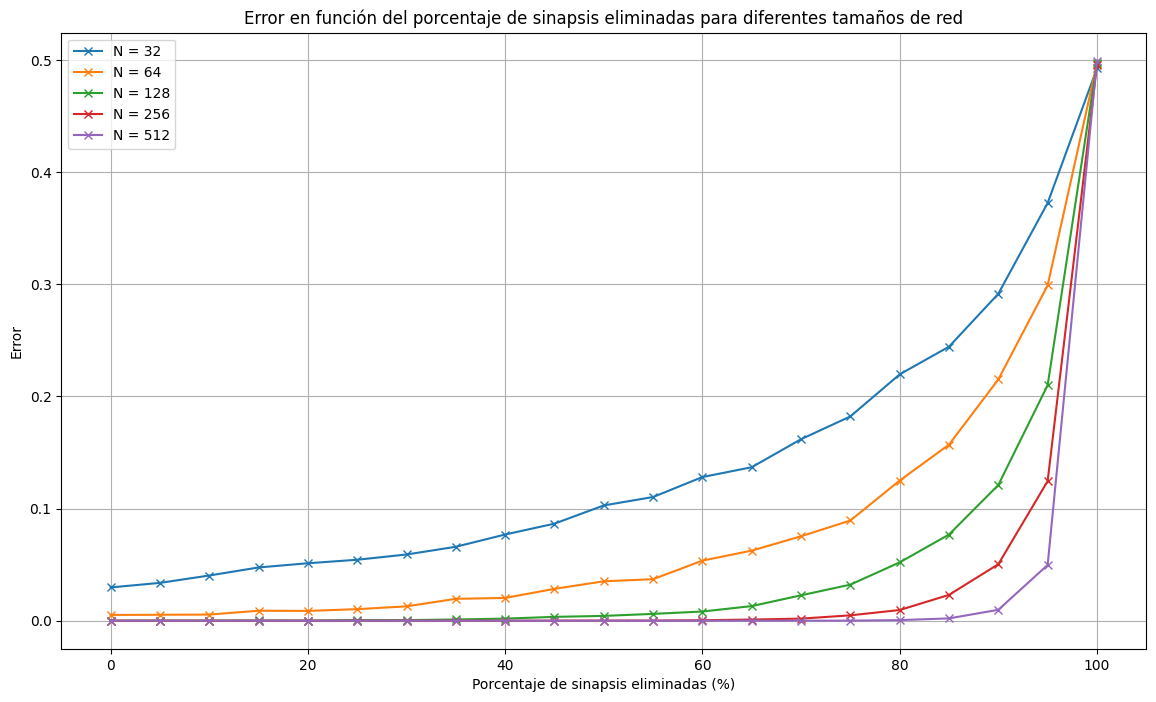

In [249]:
def plotHopfieldNetworkSynapseRemovalResults(simulation_results_synapse_removal):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))

    for result in simulation_results_synapse_removal:
        N = result["N"]
        percentages = result["percentages"]
        errors_all_experiments = result["errors"]
        mean_errors = np.mean(errors_all_experiments, axis=0)
        ax.plot(percentages, mean_errors, 'x-', label=f'N = {N}')

    ax.set_xlabel('Porcentaje de sinapsis eliminadas (%)')
    ax.set_ylabel('Error')
    ax.set_title('Error en función del porcentaje de sinapsis eliminadas para diferentes tamaños de red')
    ax.grid(True)
    ax.legend()
    plt.show()

# Ejemplo de uso de la función de graficado
plotHopfieldNetworkSynapseRemovalResults(simulation_results_synapse_removal)

In [258]:
def simulateHopfieldNetworkSynapseRemovalCapacity(Ns, percentages, num_experiments, P_error):
    results = []

    for N in Ns:
        N_results = {"N": N, "percentages": percentages, "p_max_experimental": []}
        
        for percentage in percentages:
            p_max_experimental_for_percentage = []

            for _ in range(num_experiments):
                correlated_patterns = []

                learning = True
                while learning:
                    pattern = generateRandomPattern(N)
                    correlated_patterns.append(pattern)
                    W = computeWeights(correlated_patterns)
                    W_modified = removeSynapses(W.copy(), percentage, N)

                    bad_bits = 0
                    for pat in correlated_patterns:
                        input_pattern = pat.copy()
                        bad_bits += hopfieldSyncNEW(W_modified, input_pattern)

                    P_e = float(bad_bits / (len(correlated_patterns) * N))
                    if P_e > P_error:
                        p_max_experimental_for_percentage.append(len(correlated_patterns) - 1)
                        learning = False

            N_results["p_max_experimental"].append(np.mean(p_max_experimental_for_percentage))

        results.append(N_results)

    return results

In [261]:

Ns = [32, 64, 128, 248]
percentages = np.linspace(0, 100, 21)  # De 0% a 100% en pasos de 5%
num_experiments = 3
P_error = 0.1  

simulation_results_capacity = simulateHopfieldNetworkSynapseRemovalCapacity(Ns, percentages, num_experiments, P_error)

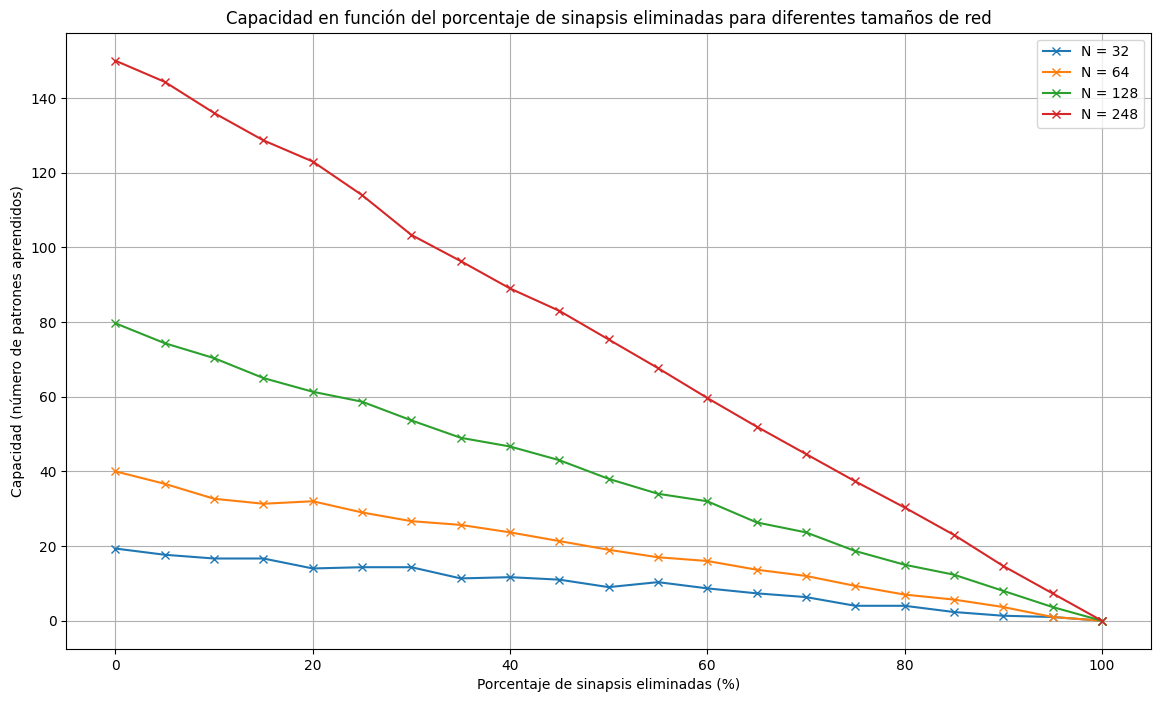

In [262]:

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

for result in simulation_results_capacity:
    N = result["N"]
    percentages = result["percentages"]
    p_max_experimental = result["p_max_experimental"]
    ax.plot(percentages, p_max_experimental, 'x-', label=f'N = {N}')

ax.set_xlabel('Porcentaje de sinapsis eliminadas (%)')
ax.set_ylabel('Capacidad (número de patrones aprendidos)')
ax.set_title('Capacidad en función del porcentaje de sinapsis eliminadas para diferentes tamaños de red')
ax.grid(True)
ax.legend()
plt.show()


4. Simular un modelo de Ising en una y dos dimensiones. Encontrar la temperatura crítica para ambos casos.

[-1  1  1 -1 -1 -1 -1  1 -1 -1]


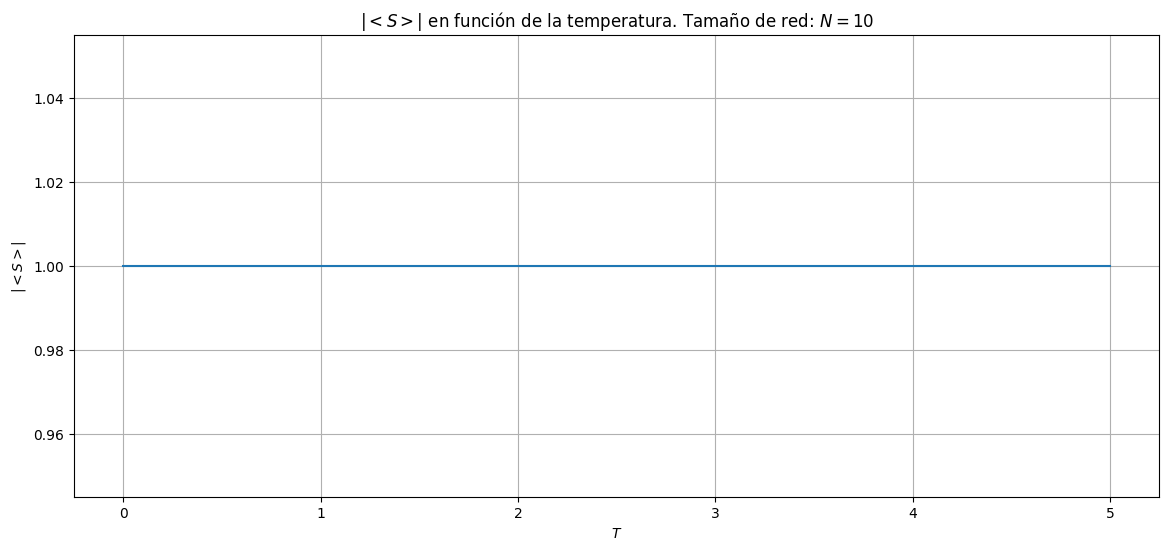

In [88]:
# Funciones

def computeWeightsIsing1D(N):
    weights = np.zeros((N, N))
    np.fill_diagonal(weights[:, 1:], 1)
    np.fill_diagonal(weights[1:, :], 1)
    
    return weights

def calculateEnergy(pattern, weights):
    aux = np.outer(pattern, pattern)
    return -0.5 * np.sum(aux * weights) 

# Constantes
T_0 = 5
dT = 0.1
N = 10

magnet = generatePatterns(N, 1)[0]
print(magnet)
weights = computeWeightsIsing1D(N)

T = T_0

for _ in range(int(T_0/dT)):
    magnetizations = []
    for i in range(1000):
        E = -0.5 * np.outer(magnet, magnet) * weights 
        random_indexes = np.random.permutation(N)
        for spin_i in random_indexes:
            E = calculateEnergy(magnet, weights)
            magnet[spin_i] = -magnet[spin_i]
            dE = calculateEnergy(magnet, weights) - E

            if dE > 0 and np.exp(-dE/T) < np.random.rand():
                magnet[spin_i] = -magnet[spin_i]
        magnetizations.append(np.abs(np.mean(magnet)))
    T -= dT

magnetizations.reverse()

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.plot(np.linspace(0, T_0, len(magnetizations)), magnetizations, label='$|<S>|$')
ax.set_title(f'$|<S>|$ en función de la temperatura. Tamaño de red: $N = {N}$')
ax.set_xlabel('$T$')
ax.set_ylabel('$|<S>|$')
ax.grid()

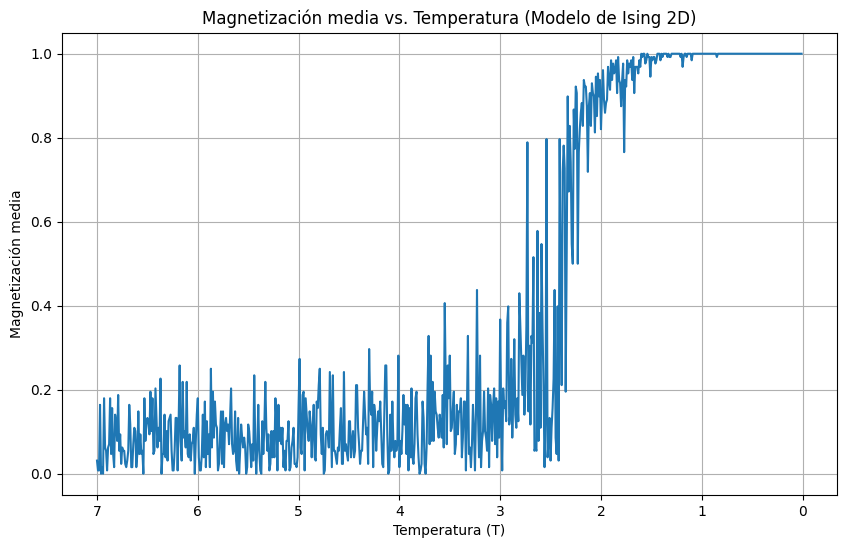

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
J = 1.0
k_B = 1.0

# Función para calcular la energía del sistema
def calculateEnergy(pattern, L):
    N = L * L
    energy = 0
    for i in range(N):
        row, col = divmod(i, L)
        S = pattern[i]
        nb_sum = 0
        nb_sum += pattern[((row - 1) % L) * L + col]  # Up
        nb_sum += pattern[((row + 1) % L) * L + col]  # Down
        nb_sum += pattern[row * L + (col - 1) % L]  # Left
        nb_sum += pattern[row * L + (col + 1) % L]  # Right
        energy += -J * S * nb_sum
    return energy / 2  # Para contar cada par de interacción una sola vez

# Función para realizar un paso de Monte Carlo
def monteCarloStep(pattern, T, L):
    N = L * L
    for _ in range(N):
        spin_i = np.random.randint(0, N)
        row, col = divmod(spin_i, L)
        S = pattern[spin_i]
        nb_sum = 0
        nb_sum += pattern[((row - 1) % L) * L + col]  # Up
        nb_sum += pattern[((row + 1) % L) * L + col]  # Down
        nb_sum += pattern[row * L + (col - 1) % L]  # Left
        nb_sum += pattern[row * L + (col + 1) % L]  # Right
        dE = 2 * J * S * nb_sum

        if dE < 0 or np.random.rand() < np.exp(-dE / (k_B * T)):
            pattern[spin_i] *= -1
    return pattern

# Simulación del modelo de Ising
def isingModelSimulation(L, T_0, dT, steps_per_T):
    N = L * L
    pattern = np.random.choice([-1, 1], size=N)
    temperatures = np.arange(T_0, 0, -dT)
    magnetizations = []

    for T in temperatures:
        for _ in range(steps_per_T):
            pattern = monteCarloStep(pattern, T, L)
        magnetizations.append(np.abs(np.mean(pattern)))
    #magnetizations.reverse()

    return temperatures, magnetizations

# Parámetros de simulación
L = 16
T_0 = 7.0
dT = 0.01
steps_per_T = 100

# Realizar la simulación
temperatures, magnetizations = isingModelSimulation(L, T_0, dT, steps_per_T)

# Invertir los datos para graficar de 0 a 5
temperatures = temperatures[::-1]
magnetizations = magnetizations[::-1]
# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(temperatures, magnetizations)
plt.xlabel('Temperatura (T)')
plt.ylabel('Magnetización media')
plt.title('Magnetización media vs. Temperatura (Modelo de Ising 2D)')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()


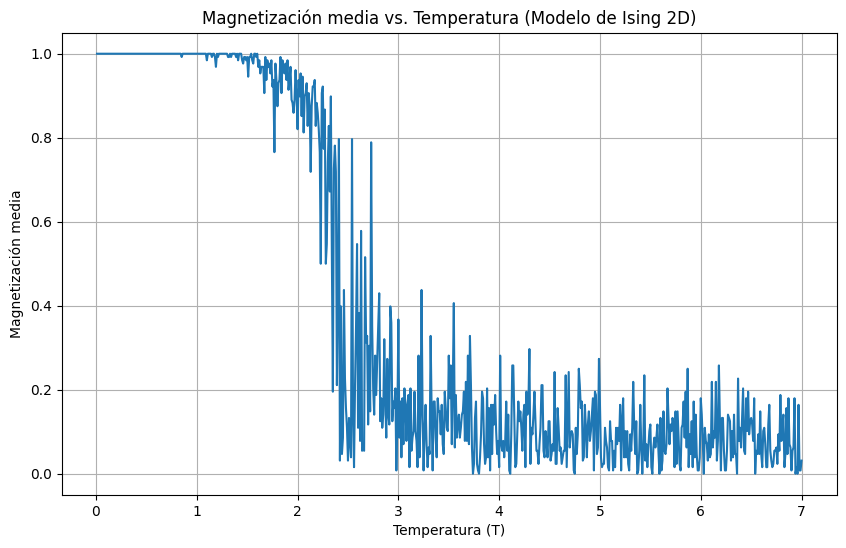

In [125]:
# Invertir los datos para graficar de 0 a 5
temperatures = temperatures[::-1]
magnetizations = magnetizations[::-1]
temperatures = temperatures[::-1]
# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(temperatures, magnetizations)
plt.xlabel('Temperatura (T)')
plt.ylabel('Magnetización media')
plt.title('Magnetización media vs. Temperatura (Modelo de Ising 2D)')
#plt.gca().invert_xaxis()
plt.grid(True)
plt.show()


Inicial magnet:  [ 1 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1
  1 -1  1 -1  1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1 -1 -1 -1  1  1
  1  1  1 -1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1 -1 -1  1 -1  1  1  1
 -1  1 -1 -1  1  1  1  1 -1  1 -1  1  1  1 -1  1  1  1 -1 -1  1  1 -1  1
  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1
  1  1 -1  1 -1 -1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1
  1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1 -1 -1  1  1  1 -1
  1  1  1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1  1  1  1 -1  1
  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1 -1
 -1 -1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1  1 -1  1  1 -1  1
  1  1  1  1 -1 -1  1 -1 -1  1 -1  1  1  1  1 -1]


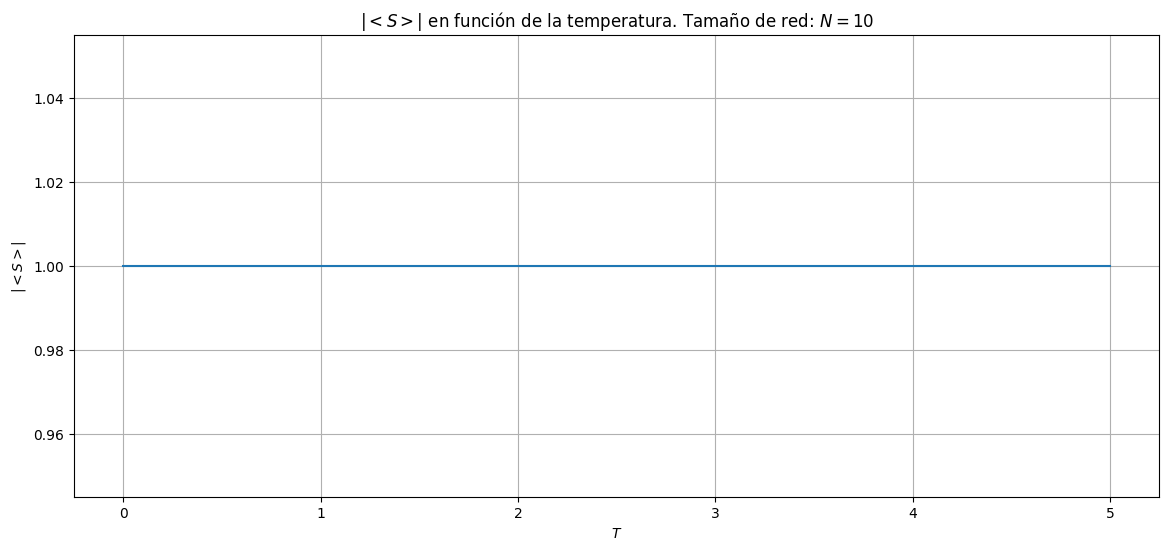

In [105]:
def computeWeightsIsing2D(L):
    N = L * L
    W = np.zeros((N, N))
    
    for i in range(N):
        row, col = divmod(i, L)
        
        # Determine the neighbors in the 2D grid
        if row > 0:  # Up
            W[i, i - L] = 1
        if row < L - 1:  # Down
            W[i, i + L] = 1
        if col > 0:  # Left
            W[i, i - 1] = 1
        if col < L - 1:  # Right
            W[i, i + 1] = 1
    
    return W


T_0 = 5
dT = 0.1

L = 16
magnet = generatePatterns(L*L, 1)[0]
#print(magnet[:4])
#print(magnet[4:8])
#print(magnet[8:12])
#print(magnet[12:16])
print("Inicial magnet: ", magnet)
weights = computeWeightsIsing2D(L)

T = T_0

for _ in range(int(T_0/dT)):
    magnetizations = []
    for i in range(100):
        #E = calculateEnergy(magnet, weights) 
        random_indexes = np.random.permutation(L*L)
        for spin_i in random_indexes:
            E = calculateEnergy(magnet, weights)
            #print("Energy: ", E)
            magnet[spin_i] = -magnet[spin_i]
            #print(magnet)
            dE = calculateEnergy(magnet, weights) - E

            if dE > 0 and np.exp(-dE/T) < np.random.rand():
                magnet[spin_i] = -magnet[spin_i]
        magnetizations.append(np.abs(np.mean(magnet)))
    T -= dT

magnetizations.reverse()

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.plot(np.linspace(0, T_0, len(magnetizations)), magnetizations, label='$|<S>|$')
ax.set_title(f'$|<S>|$ en función de la temperatura. Tamaño de red: $N = {N}$')
ax.set_xlabel('$T$')
ax.set_ylabel('$|<S>|$')
ax.grid()


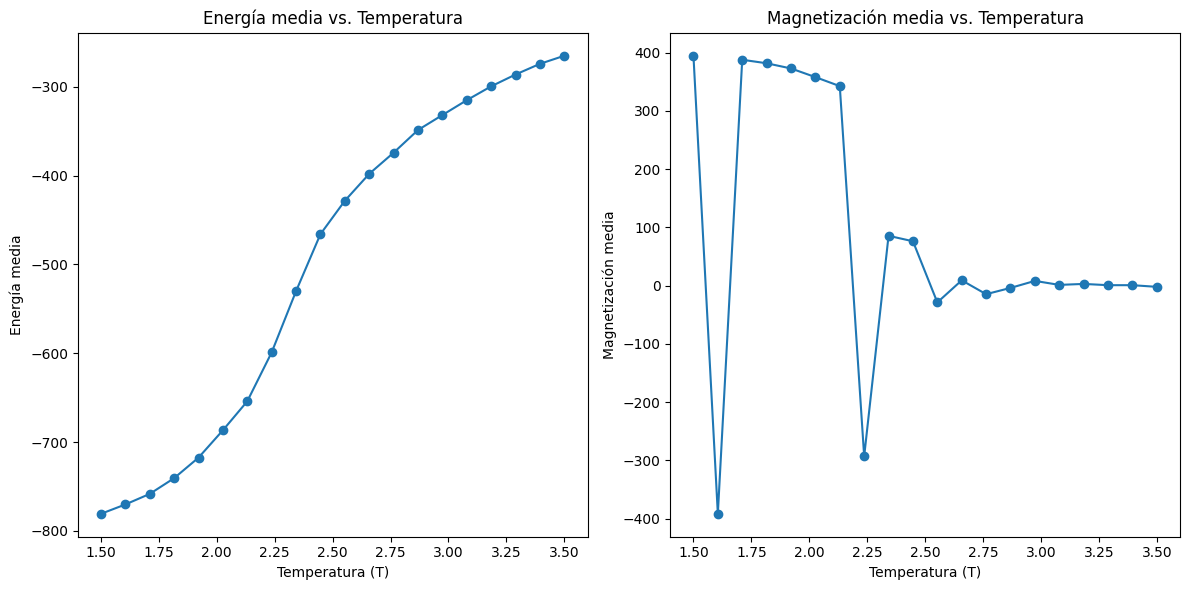

In [73]:
# Constantes
J = 1.0
k_B = 1.0

# Función para calcular la energía del sistema
def calculateEnergy(spins, J):
    energy = 0
    for i in range(len(spins)):
        for j in range(len(spins[0])):
            S = spins[i, j]
            nb = spins[(i+1)%N, j] + spins[i, (j+1)%N] + spins[(i-1)%N, j] + spins[i, (j-1)%N]
            energy += -J * S * nb
    return energy / 2  # Para contar cada par de interacción una sola vez

# Función para calcular la magnetización del sistema
def calculate_magnetization(spins):
    return np.sum(spins)

# Función para realizar un paso de Monte Carlo
def monte_carlo_step(spins, T, J):
    N = len(spins)
    for _ in range(N*N):
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        S = spins[i, j]
        nb = spins[(i+1)%N, j] + spins[i, (j+1)%N] + spins[(i-1)%N, j] + spins[i, (j-1)%N]
        dE = 2 * J * S * nb
        if dE < 0 or np.random.rand() < np.exp(-dE / (k_B * T)):
            spins[i, j] *= -1
    return spins

# Simulación del modelo de Ising
def ising_model_simulation(N, T, steps):
    spins = np.random.choice([-1, 1], size=(N, N))
    energies = []
    magnetizations = []
    for step in range(steps):
        spins = monte_carlo_step(spins, T, J)
        energies.append(calculateEnergy(spins, J))
        magnetizations.append(calculate_magnetization(spins))
    return energies, magnetizations

# Parámetros de simulación
N = 20
steps = 10000
temperatures = np.linspace(1.5, 3.5, 20)

# Realizar simulaciones para diferentes temperaturas
avg_energies = []
avg_magnetizations = []

for T in temperatures:
    energies, magnetizations = ising_model_simulation(N, T, steps)
    avg_energies.append(np.mean(energies[int(steps/2):]))  # Promediar sobre la segunda mitad de las iteraciones
    avg_magnetizations.append(np.mean(magnetizations[int(steps/2):]))

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(temperatures, avg_energies, 'o-')
plt.xlabel('Temperatura (T)')
plt.ylabel('Energía media')
plt.title('Energía media vs. Temperatura')

plt.subplot(1, 2, 2)
plt.plot(temperatures, avg_magnetizations, 'o-')
plt.xlabel('Temperatura (T)')
plt.ylabel('Magnetización media')
plt.title('Magnetización media vs. Temperatura')

plt.tight_layout()
plt.show()
